# **Store Sales - Time Series Forecasting**


## **0. 대회 소개**


- 시계열 예측을 사용하여 에콰도르 기반의 대형 식료품 소매업체인 Corporación Favorita의 `매장 판매량`을 예측하는 것
  - Favorita 매장에서 판매되는 수천 개의 제품군들의 `단위 판매량`을 더 정확하게 예측하는 모델을 구축하고자 함


#### **평가 지표**
- Root Mean Squared Logarithmic Error(`RMSLE`)
  - 다음과 같이 계산  
  $ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $
  - $n$: 총 인스턴스 수
  - $ \hat{y}_i$: 인스턴스 $i$에 대한 타겟의 예측값
  - $y_i$는 인스턴스 $i$에 대한 타겟의 실제값

---

## **1. 데이터 살펴보기**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **1-1. 훈련 데이터**
- 날짜, 매장 및 제품 정보, 해당 제품이 프로모션되었는지 여부, 그리고 매출 숫자가 포함되어 있음
- 추가 파일에는 모델을 구축하는 데 유용할 수 있는 보충 정보가 포함되어 있음



#### **a) train.csv**  
- 학습용 데이터  

**컬럼 설명**   
- `id`: 각 데이터를 구분하기 위한 식별자
  - 300만 건의 데이터
- `date`: 판매일자
  - 기간) 2013/01/01 ~ 2017/08/15
- `store_nbr`: 매장 고유 식별번호
  - 1 ~ 54번
- `family`: 판매되는 제품 유형
  - 33개의 제품군
- `sales`: 특정 날짜에 특정 매장에서 제품군의 총 매출
  - 제품은 분수 단위로 판매될 수 있기 때문에 소수 값이 가능  
    (예: 1.5 kg의 치즈, 1 봉지의 감자칩 등)  
- `onpromotion`: 특정 날짜에 매장에서 프로모션되고 있는 제품군의 총 수량

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/train.csv')
train.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

#### **b) stores.csv**
- 매장 메타데이터  

**컬렴 설명**
  - `store_nbr`: 매장 고유 식별번호
  - `city`: 매장이 위치한 도시
    - Quito, Guayaquil, Santa Domingo, Cuenca, Latacunga
  - `state`: 매장이 위치한 주
    - Pichincha, Guayas, Santo Domingo de los Tsachilas, Azuay, Manabi
  - `type`: 매장 유형
    - A, B, C, D, E
  - `cluster`: 유사한 매장들의 그룹
    - 1 ~ 17

In [6]:
stores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/stores.csv')
stores.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [7]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [8]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

#### **c) oil.csv**
- 일일 유가
- 학습 및 테스트 데이터 기간 모두의 값을 포함
- 에콰도르는 석유 의존국임
  - 석유 가격의 변동에 매우 취약함

**컬럼 설명**  
- `date`: 관측 일자
  - 기간) 2013/01/01 ~ 2017/08/31
- `dcoilwtico`: 유가

In [9]:
oil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/oil.csv')
oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [10]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [11]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

#### **d) holidays_events.csv**
- 휴일 및 이벤트 메타데이터
- `date`: 일자
  - 2012/03/12 ~ 2017/12/26
- `type` : 휴일 유형
  - Holiday, Event, Additional, Transfer, Bridge
- `locale`: 규모
  - National, Local, Regional
- `locale_name`: 지역명
  - Ecuador, Quito, Riobamba, Guaranda, Latacunga
- `description`: 설명
- `transferred`: 대체 여부
  - True, False


**Type**  
- Transfer
  - 달력상 날짜는 유지하되, 정부에 의해 다른 날짜로 변경된 휴일
  - 이렇게 변경된 날은 휴일로 취급되지만, 실제로는 일반적인 날과 유사함
> 실제 축하되는 날짜를 찾으려면 "type"이 "Transfer"인 해당 행을 확인하면 됨
  - 예를 들어, Independencia de Guayaquil 휴일은 2012-10-09에서 2012-10-12로 이전되었으며, 이는 2012-10-12에 실제로 축하된 것을 의미
- Bridge
  - 휴일 기간을 연장하기 위해 추가된 날짜
  - 이러한 날은 휴일로 취급되지만 실제로는 보통 근무일임
    - 이러한 날은 보통 Work Day 유형으로 보상됨
    > 휴일이 아닌 보통 근무일(예: 토요일)로, Bridge를 보상하기 위한 것
  - 대체공휴일 느낌
- Additional
  - 보통 달력상 휴일에 추가된 날짜
  - 일반적으로 크리스마스 주변에 발생하며, 이러한 날은 일반적인 휴일로 취급됨

In [12]:
holidays_events = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/holidays_events.csv')
holidays_events.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [13]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [14]:
holidays_events['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [15]:
holidays_events['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [16]:
holidays_events.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

#### **e) transaction.csv**
- 거래 데이터로, 매장에 방문한 사람 수 또는 하루에 생성된 송장 수를 의미
  - 학습 데이터의 매출(sales) 컬럼과 매우 상관 관계가 있음
  - 이를 통해 매장의 매출 패턴을 이해할 수 있음
- `date`: 일자
  - 2013/01/01 ~ 2017/08/15
- `store_nbr`: 가게 고유번호
- `transactions`: 거래량

In [17]:
transaction = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트//transactions.csv')
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [18]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


### **1-2. 테스트 데이터**
- 기간) 2017/08/16 ~ 2017/08/31

In [19]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


### **1-3. 제출용 파일**

In [21]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/sample_submission.csv')
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


---

## **2. 전처리**



### **2-1. oil 데이터프레임 결측치 처리**

In [22]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

* 유가 결측치 43개 존재

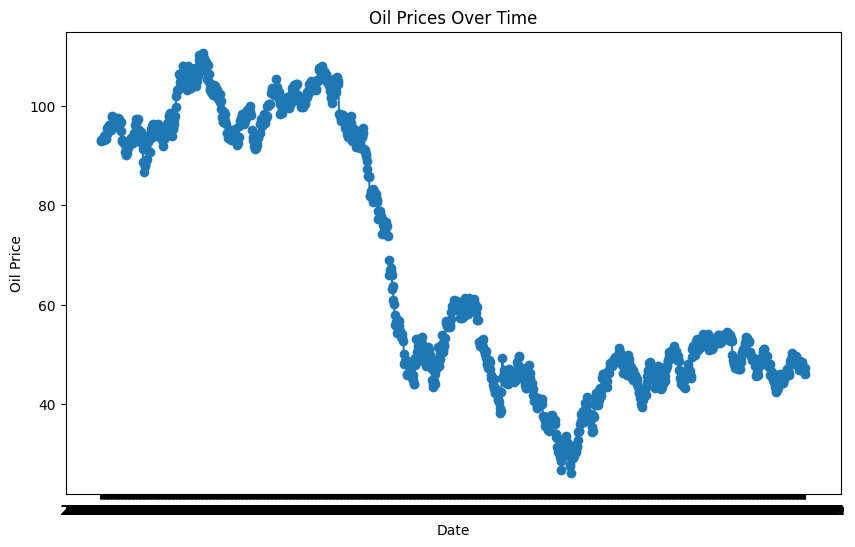

In [23]:
# 유가 시계열 그래프
plt.figure(figsize=(10, 6))
plt.plot(oil['date'], oil['dcoilwtico'], marker='o', linestyle='-')
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')

plt.show()

* **선형 보간**

    : 결측값이 있는 경우, 선형 보간은 주어진 두 데이터 포인트 사이의 직선상에서 결측값을 추정한다. 이것은 시계열 데이터에서 쓸만한 방법 중 하나로, 데이터의 추세를 고려하여 결측값을 대체하는 데 사용된다.

    -> 주어진 두 점 사이의 직선을 사용하여 두 점 사이의 값들을 추정하는 방법

    -> 시계열 데이터나 순차적인 데이터에서 결측값을 채우는 데 자주 사용

    -> Pandas의 `interpolate` 메서드에서 `method='linear'` 옵션을 사용하면, 데이터프레임의 시리즈나 열에 대해 선형 보간을 수행할 수 있음



In [24]:
# 'dcoilwtico'(유가) 컬럼 결측치 선형 보간으로 채우기
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

In [25]:
oil.isnull().sum()

date          0
dcoilwtico    1
dtype: int64

* 여전히 결측치 1개가 남아 있음
    
    -> 첫 날의 결측치임

    -> 둘째 날의 값으로 똑같게 변경해줘도 데이터에 크게 변동 없음

In [26]:
oil.at[0, 'dcoilwtico'] = oil.at[1, 'dcoilwtico']
oil['dcoilwtico']

0       93.14
1       93.14
2       92.97
3       93.12
4       93.20
        ...  
1213    47.65
1214    46.40
1215    46.46
1216    45.96
1217    47.26
Name: dcoilwtico, Length: 1218, dtype: float64

In [27]:
oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

* 더이상 결측치 없음

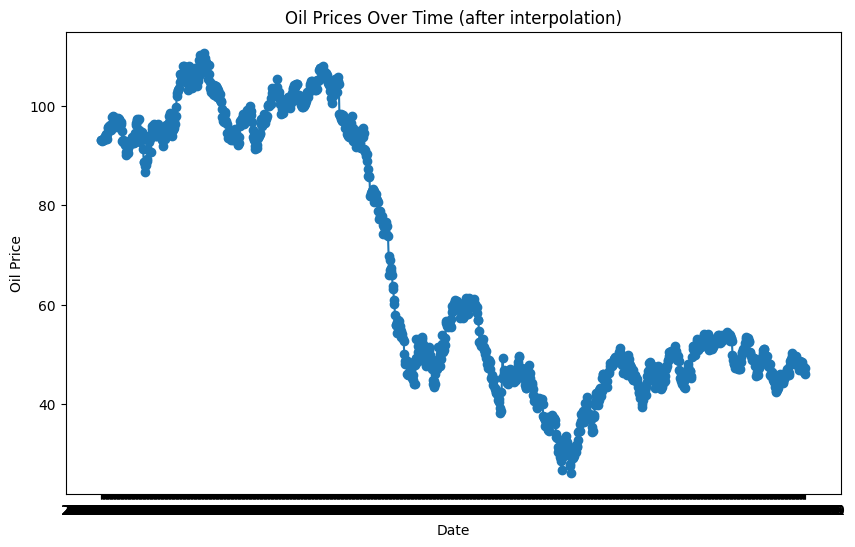

In [28]:
# 결측치 처리 후 유가 시계열 그래프
plt.figure(figsize=(10, 6))
plt.plot(oil['date'], oil['dcoilwtico'], marker='o', linestyle='-')
plt.title('Oil Prices Over Time (after interpolation)')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

---

### **2-2. holiday 데이터프레임 전처리**

* 'transferred' 공휴일은 공식적으로 공휴일에 해당하지만, 정부에 의해 다른 날짜로 옮겨졌다. 'transferred'은 공휴일이라기 보다 일반적인 날에 가깝다. 실제로 공휴일이 기념된 날을 찾으려면, type이 Transfer인 해당 행을 찾아야 한다.

* 예를 들어, Independencia de Guayaquil 휴일이 2012-10-09에서 2012-10-12로 옮겨졌는데, 이것은 2012-10-12에 기념되었다는 것을 의미한다.

In [29]:
holidays_events[(holidays_events['transferred'] == True) | (holidays_events['type'] == 'Transfer')].head()

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True


* 대회에서는 'transferred'된 공휴일은 평상시처럼 처리해야 한다고 하기 때문에 데이터에 영향을 미치지 않도록 type을 'Normal'으로 변경한다.

* 'transferred'된 날은 일반 공휴일로 처리한다.

In [30]:
holidays_events.loc[holidays_events['transferred'], 'type'] = 'Normal'
holidays_events.loc[holidays_events['type'] == 'Transfer', 'type'] = 'Holiday'

* 'transferred' 칼럼은 모두 처리되었으므로 칼럼을 삭제함

In [31]:
holidays_events.drop('transferred', axis=1, inplace=True)
holidays_events

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba
...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3
346,2017-12-23,Additional,National,Ecuador,Navidad-2
347,2017-12-24,Additional,National,Ecuador,Navidad-1
348,2017-12-25,Holiday,National,Ecuador,Navidad


In [32]:
holidays_events['type'].unique()

array(['Holiday', 'Normal', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

* 또한 'Bridge'는 휴일에 추가되기 때문에 공휴일로 볼 수 있다.

In [33]:
holidays_events.loc[holidays_events['type'] == 'Bridge', 'type'] = 'Holiday'
holidays_events

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba
...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3
346,2017-12-23,Additional,National,Ecuador,Navidad-2
347,2017-12-24,Additional,National,Ecuador,Navidad-1
348,2017-12-25,Holiday,National,Ecuador,Navidad


In [34]:
holidays_events['type'].unique()

array(['Holiday', 'Normal', 'Additional', 'Work Day', 'Event'],
      dtype=object)

---

## **3. 데이터프레임 병합**
- `date`열의 경우 datetime으로 데이터형 변환 후 병합


In [35]:
# date 열을 datetime으로 변환
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

* stores의 type과 holidays_events의 type 칼럼명 중복

     -> holidays_events의 type을 category로 명칭 변경


In [36]:
# 'type' 열 이름을 'category'로 변경
holidays_events = holidays_events.rename(columns={'type': 'category'})

- `train`의 모든 행은 결과 데이터프레임에 포함되며, 병합하려는 데이터프레임의 정보는 병합 대상인 열을 기준으로 매칭되는 경우에만 병합

* holidays_events 데이터 프레임을 병합하면 매일이 특별한 날은 아니므로 결측값이 발생한다.

    -> 이를 위해 결측치를 문자열 "None"으로 채운다.

In [37]:
# oil, holidays_events 데이터프레임 - 날짜를 기준으로 merge
train = pd.merge(train, oil, on = 'date', how = 'left')
train = pd.merge(train, holidays_events, on = 'date', how = 'left')

# 결측치 채우기
train = train.fillna("None")

# stores 데이터프레임 - 매장 고유번호를 기준으로 merge
train = pd.merge(train, stores, on = 'store_nbr', how = 'left')

* 병합 결과 확인

In [38]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,category,locale,locale_name,description,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   dcoilwtico   object        
 7   category     object        
 8   locale       object        
 9   locale_name  object        
 10  description  object        
 11  city         object        
 12  state        object        
 13  type         object        
 14  cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(9)
memory usage: 372.8+ MB


In [40]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
category       0
locale         0
locale_name    0
description    0
city           0
state          0
type           0
cluster        0
dtype: int64

* 결측치가 하나도 존재하지 않음

---

## **4. 추가 새로운 데이터프레임**

In [41]:
new_train = train.copy()


### **4-1. 'payday' 칼럼 추가**

* 공공기관의 임금은 2주 간격으로 15일과 그 달의 마지막 날에 지급된다. 이에 따라 슈퍼마켓 매출이 영향을 받을 수 있다.



In [42]:
# 달의 마지막 날인지 표시하는 칼럼 추가
new_train["date"] = pd.to_datetime(new_train.date)
new_train['last_day_of_month'] = new_train['date'].dt.is_month_end.astype(int)

In [43]:
# 날짜를 연도, 월, 일로 구분
new_train['day'] = new_train['date'].dt.day
new_train['month'] = new_train['date'].dt.month
new_train['year'] = new_train['date'].dt.year
new_train.drop('date', axis=1, inplace=True)

In [44]:
# 'payday' 칼럼 추가
new_train['payday'] = ((new_train['last_day_of_month'] == 1) | (new_train['day'] == 15)).astype(int)
new_train[new_train['payday'] == 1].head(100)

,id,store_nbr,family,sales,onpromotion,dcoilwtico,category,locale,locale_name,description,city,state,type,cluster,last_day_of_month,day,month,year,payday
24948,24948,1,AUTOMOTIVE,1.0,0,93.26,None,None,None,None,Quito,Pichincha,D,13,0,15,1,2013,1
24949,24949,1,BABY CARE,0.0,0,93.26,None,None,None,None,Quito,Pichincha,D,13,0,15,1,2013,1
24950,24950,1,BEAUTY,0.0,0,93.26,None,None,None,None,Quito,Pichincha,D,13,0,15,1,2013,1
24951,24951,1,BEVERAGES,1149.0,0,93.26,None,None,None,None,Quito,Pichincha,D,13,0,15,1,2013,1
24952,24952,1,BOOKS,0.0,0,93.26,None,None,None,None,Quito,Pichincha,D,13,0,15,1,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25043,25043,11,PREPARED FOODS,16.0,0,93.26,None,None,None,None,Cayambe,Pichincha,B,6,0,15,1,2013,1
25044,25044,11,PRODUCE,0.0,0,93.26,None,None,None,None,Cayambe,Pichincha,B,6,0,15,1,2013,1
25045,25045,11,SCHOOL AND OFFICE SUPPLIES,0.0,0,93.26,None,None,None,None,Cayambe,Pichincha,B,6,0,15,1,2013,1
25046,25046,11,SEAFOOD,6.0,0,93.26,None,None,None,None,Cayambe,Pichincha,B,6,0,15,1,2013,1


In [45]:
# 'last_day_of_month' 칼럼 삭제
new_train.drop('last_day_of_month', axis=1, inplace=True)
new_train.head()

,id,store_nbr,family,sales,onpromotion,dcoilwtico,category,locale,locale_name,description,city,state,type,cluster,day,month,year,payday
0,0,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0
1,1,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0
2,2,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0
3,3,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0
4,4,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0


### **4-2. 특정 데이터 삭제**

* 2016년 4월 16일, 에콰도르에서 규모 7.8의 지진이 발생했다. 사람들은 지진이 발생한 후, 몇 주 동안 물과 다른 우선적으로 필요한 제품들을 기부하는 구호 활동에 힘을 모았다. 이는 슈퍼마켓 판매에 큰 영향을 미친다.

In [46]:
# 지진이 발생한 달과 그 다음 달 데이터 삭제
indexes_to_drop = new_train[(new_train['year'] == 2016) & ((new_train['month'] == 4) | (new_train['month'] == 5))].index
new_train = new_train.drop(indexes_to_drop)
new_train = new_train.reset_index(drop=True)

In [47]:
# 잘 삭제 되었는지 확인
new_train[(new_train['year'] == 2016) & ((new_train['month'] == 4) | (new_train['month'] == 5))]

,id,store_nbr,family,sales,onpromotion,dcoilwtico,category,locale,locale_name,description,city,state,type,cluster,day,month,year,payday


In [48]:
new_train.head()

,id,store_nbr,family,sales,onpromotion,dcoilwtico,category,locale,locale_name,description,city,state,type,cluster,day,month,year,payday
0,0,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0
1,1,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0
2,2,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0
3,3,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0
4,4,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13,1,1,2013,0


---

## **5. 시각화**

### **5-1. 상관관계**

<ipython-input-49-4eb972893560>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfcorr = train.corr()


<Axes: >

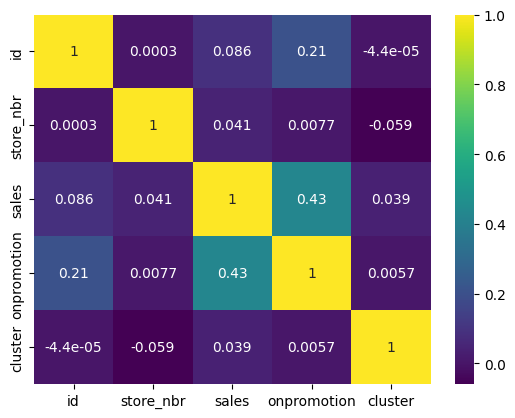

In [49]:
# 상관관계
dfcorr = train.corr()
plt.figure()
sns.heatmap(dfcorr, annot=True, cmap='viridis', cbar=True)

* sales과 onpromotion의 상관관계가 0.43으로 높음

---

### **5-2. 제품 유형에 따른 sales**

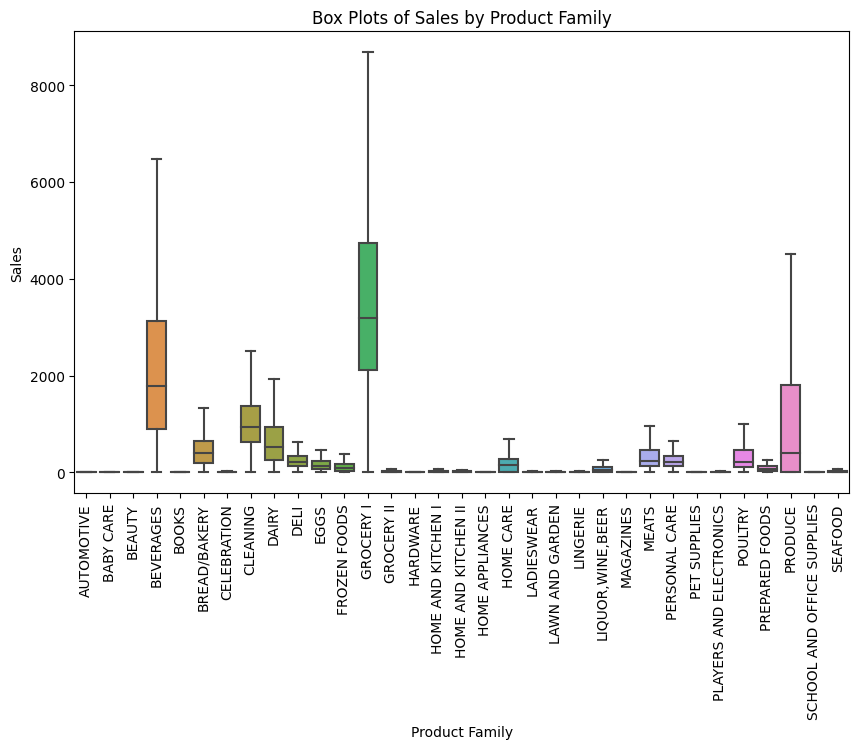

In [50]:
plt.figure(figsize=(10,6))
sns.boxplot(x=train['family'], y=train['sales'], showfliers = False)

plt.xticks(rotation=90)
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.title('Box Plots of Sales by Product Family')
plt.show()

---

### **5-3. 매장에 따른 sales**

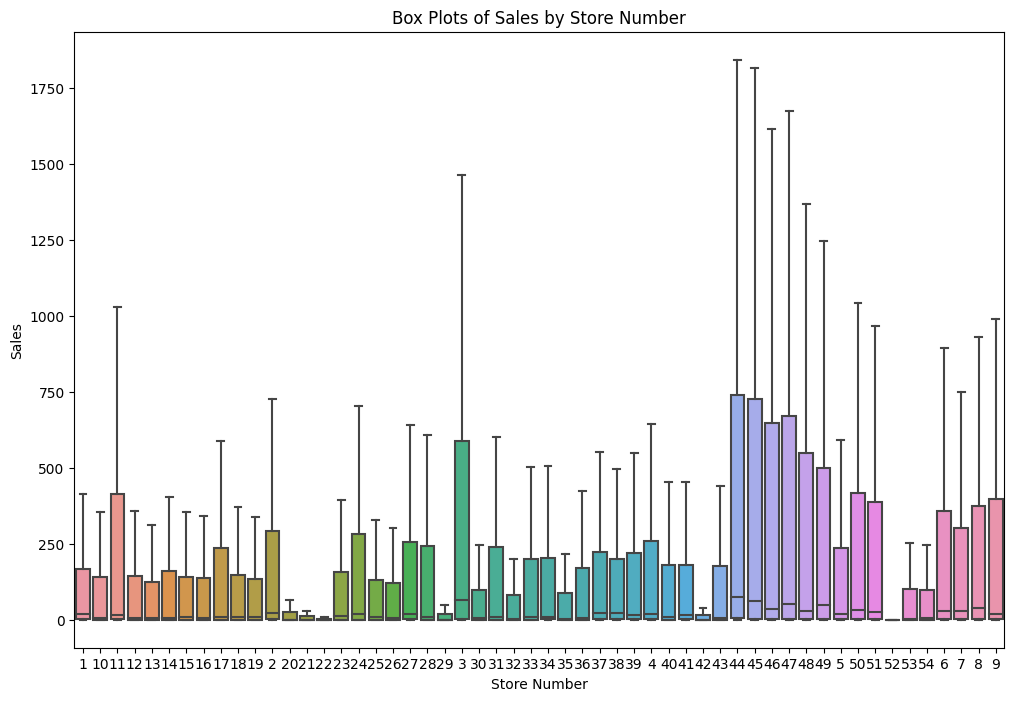

In [51]:
plt.figure(figsize=(12,8))
sns.boxplot(x=train['store_nbr'].astype(str), y=train['sales'], showfliers = False)

plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.title('Box Plots of Sales by Store Number')
plt.show()

---

### **5-4. stores 관련 범주형 변수의 카테고리별 빈도**

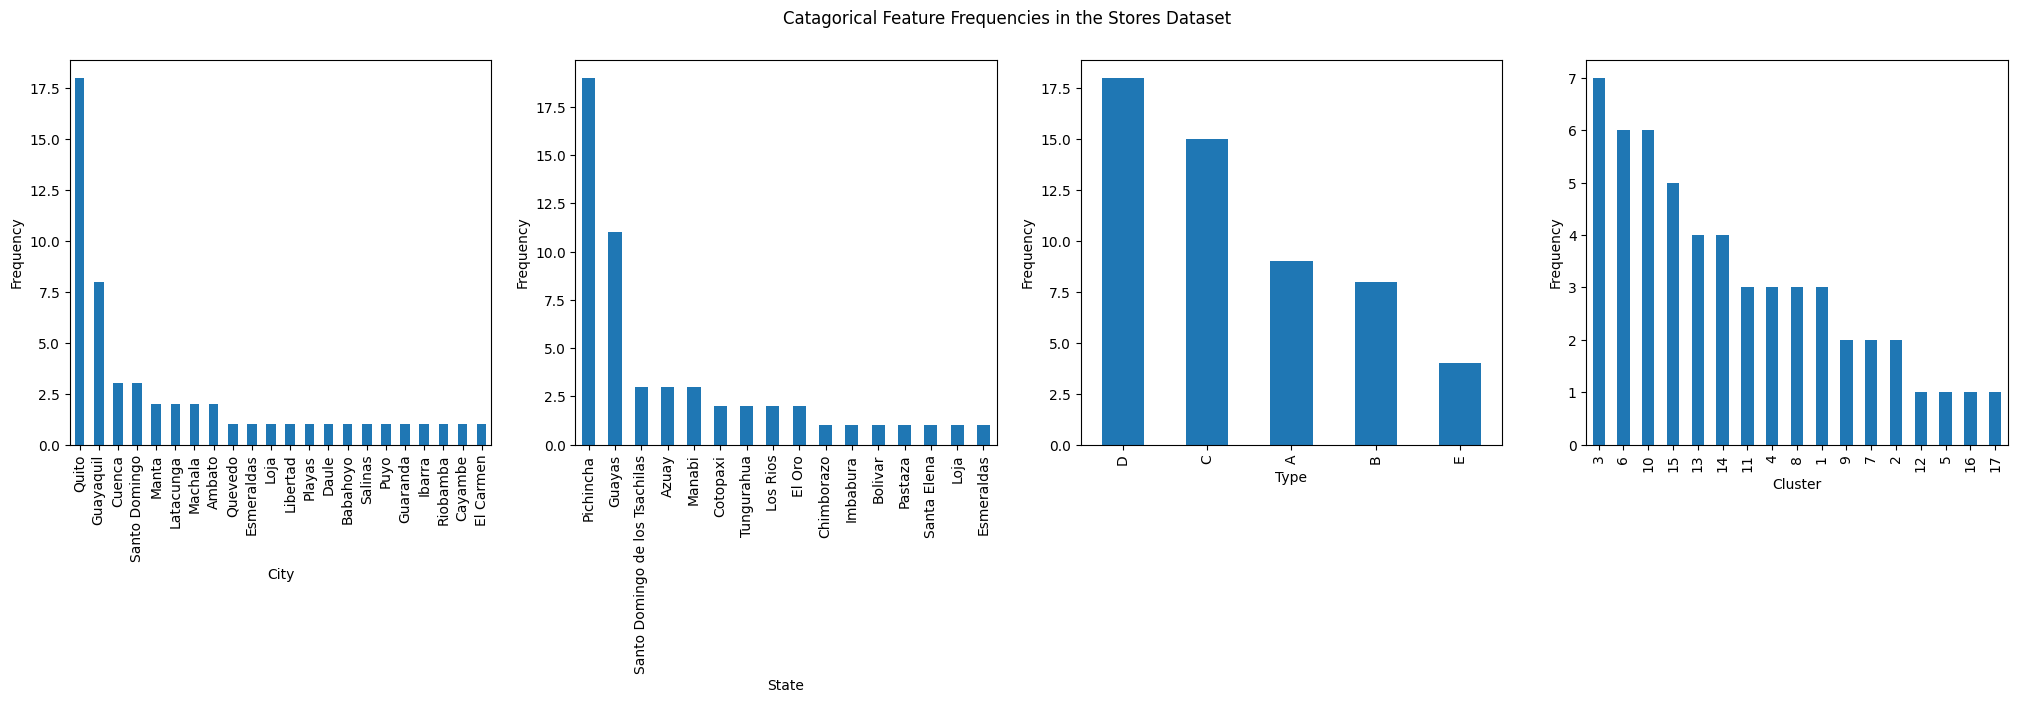

In [52]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
stores['city'].value_counts().plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Frequency')


plt.subplot(1,4,2)
stores['state'].value_counts().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Frequency')

plt.subplot(1,4,3)
stores['type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Frequency')


plt.subplot(1,4,4)
stores['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')

plt.suptitle('Catagorical Feature Frequencies in the Stores Dataset')
plt.show()

---

### **5-4. stores 관련 범주형 변수와 sales의 관계**

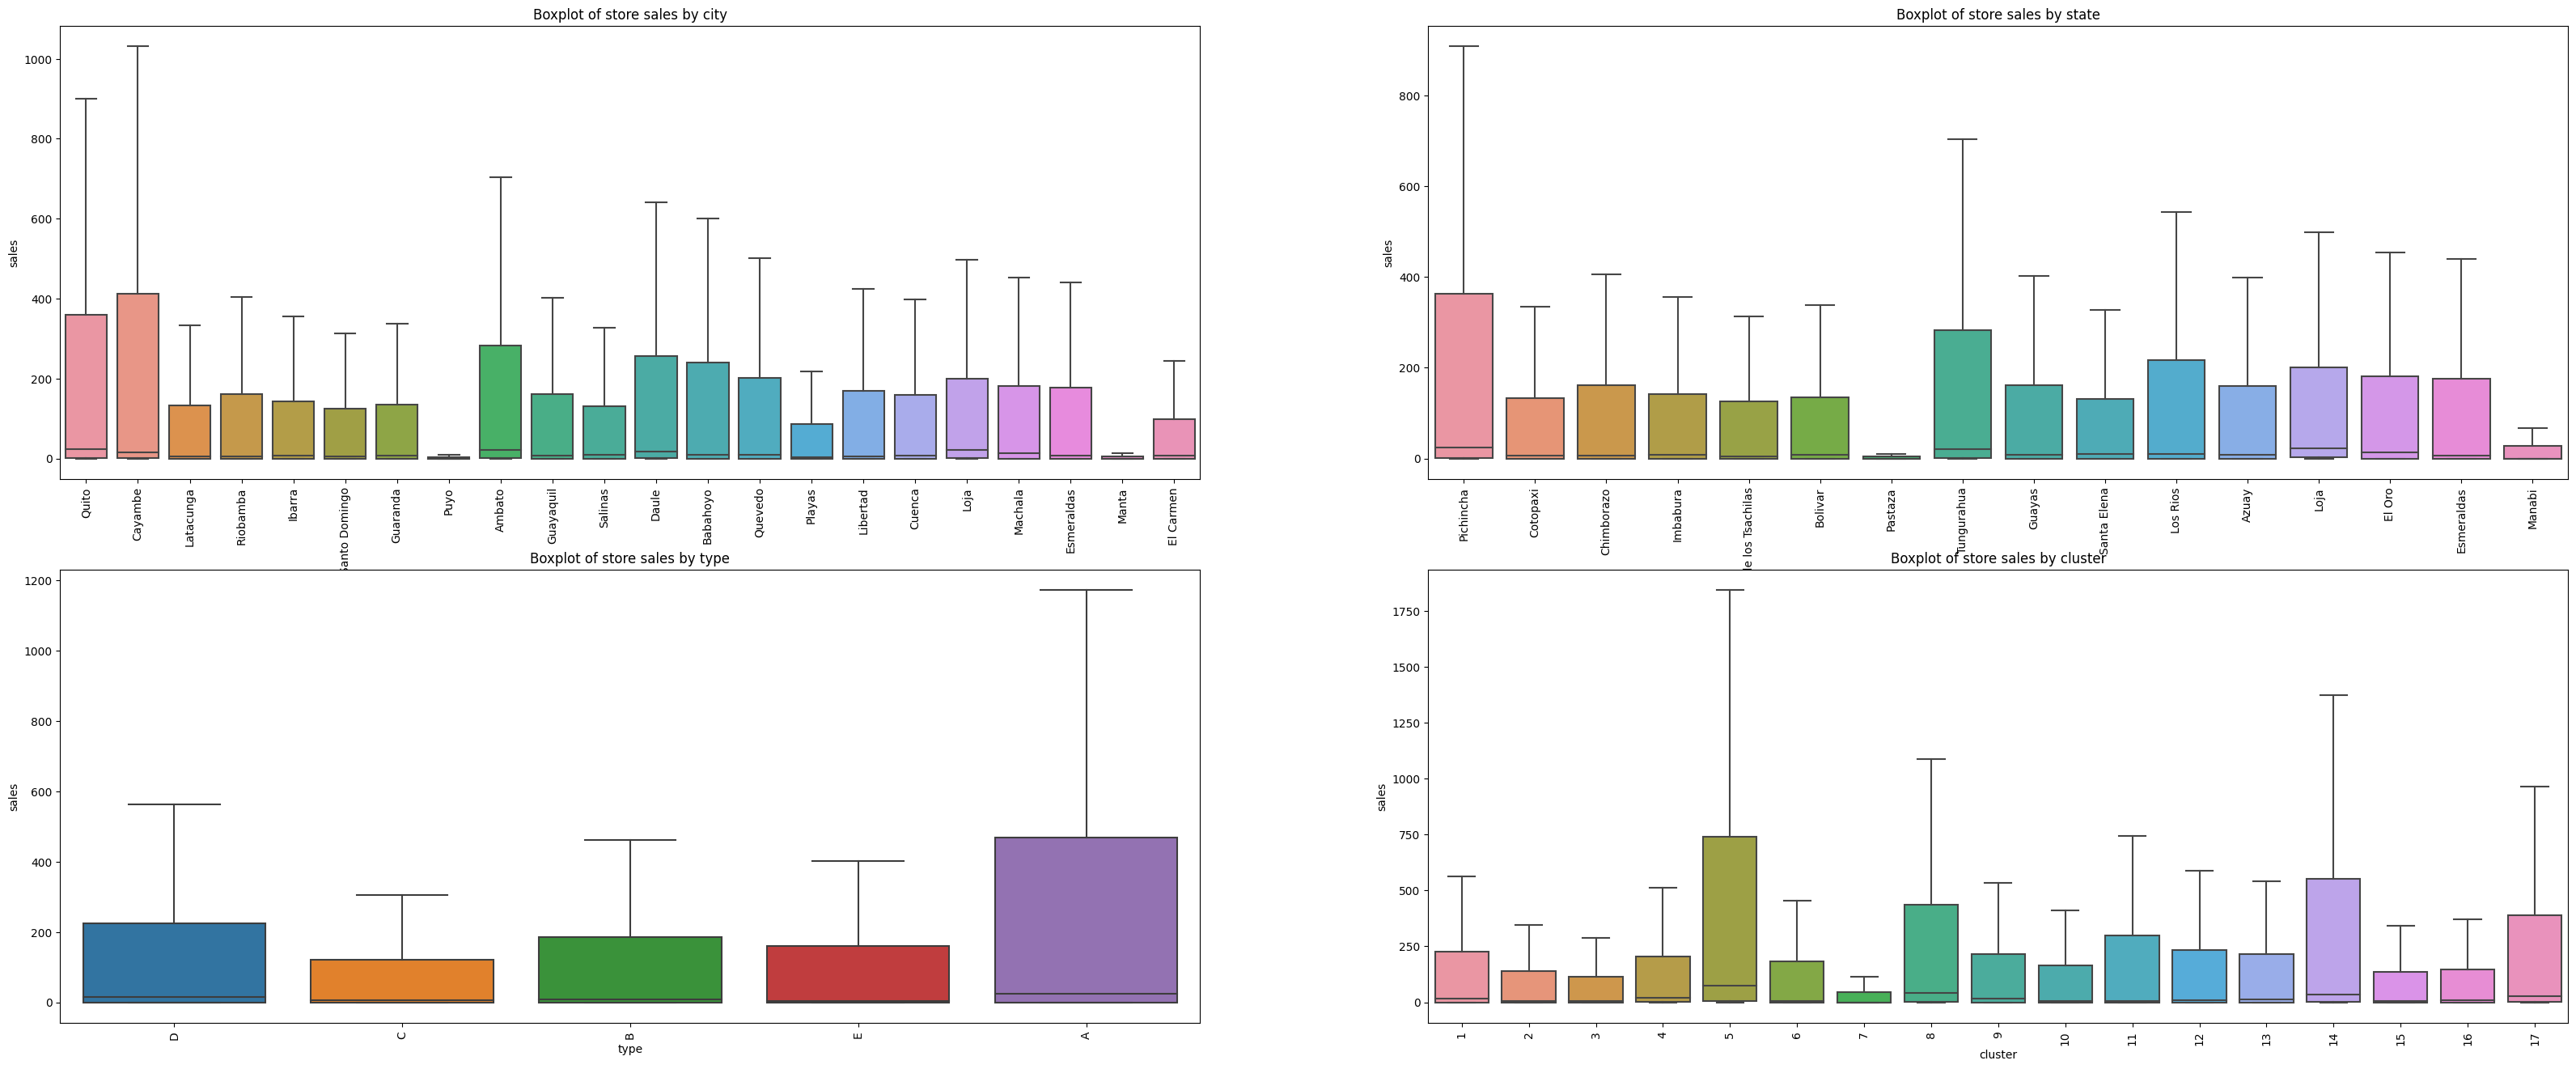

In [53]:
plt.figure(figsize=(40,16))

plt.subplot(2,2,1)
sns.boxplot(x=train['city'], y=train['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by city')

plt.subplot(2,2,2)
sns.boxplot(x=train['state'], y=train['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by state')

plt.subplot(2,2,3)
sns.boxplot(x=train['type'], y=train['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by type')

plt.subplot(2,2,4)
sns.boxplot(x=train['cluster'], y=train['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by cluster')

plt.show()

---

### **5-4. 유가와 평균 sales의 관계**

In [54]:
sales_oil = train.groupby(['date']).mean('sales').merge(oil, how='left', on='date')
pearson_correlation = sales_oil.corr().loc['sales','dcoilwtico']
pearson_correlation

<ipython-input-54-41247e338082>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_correlation = sales_oil.corr().loc['sales','dcoilwtico']


-0.6901445257663238

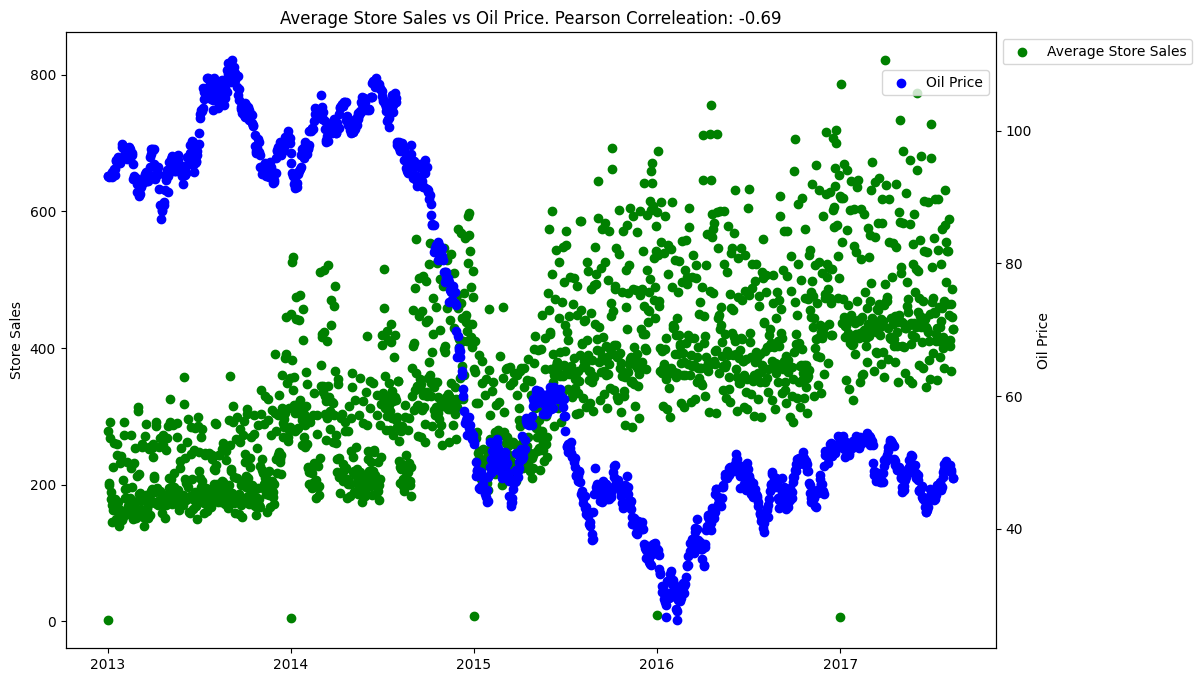

In [55]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

ax1.scatter(sales_oil['date'], sales_oil['sales'], color="g", label='Average Store Sales')
ax1.set_ylabel('Store Sales')

ax2.scatter(sales_oil['date'], sales_oil['dcoilwtico'], color="b", label='Oil Price')
ax2.set_ylabel('Oil Price')

ax1.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1,0.95))

plt.title(f'Average Store Sales vs Oil Price. Pearson Correleation: {pearson_correlation:.2f}')
plt.show()

---

## **6. 모델링**

### **6-1. 원핫인코딩**

In [ ]:
# 범주형 변수
non_numeric_columns = train.select_dtypes(exclude='number').columns

# 원핫 인코딩
df_train = pd.get_dummies(train, columns=non_numeric_columns)
df_train.dtypes

In [ ]:
df_train.head()

### **6-2. 스케일링**

In [ ]:
# X와 y 구분
X = df_train.drop('sales', axis=1)
X.drop('id', axis=1, inplace=True)

y = df_train['sales']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# scaling data
#scaler = StandardScaler()
#scaler.fit(df_train)
#scaled_df_train = scaler.transform(df_train)
